## Info


/data/
 - /{runNumber}/
   - /depth/ - contains 1 channel depth images
      - fileNames: depth{stepNum}.png
   - /rgb/ - contains 3 channel rgb images
      - fileNames: rgb{stepNum}.png
   - /states/ - contains csv files of the format:
      - endEffectorPt1X, endEffectorPt1Y, endEffectorPt2X, endEffectorPt2Y, endEffectorPt3X, endEffectorPt3Y, isOpen (boolean: {0 = closed, 1 = open})
      - endEffectorX, endEffectorY, endEffectorZ, endEffectorRoll, endEffectorPitch, endEffectorYaw
      - fileNames: states{stepNum}.csv

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
from VRNet import VRNet
from VRNet import VRDataLoader

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
rgb mean:  tensor([0.0019, 0.0017, 0.0015])
rgb std:  tensor([0.0004, 0.0005, 0.0006])
depth mean:  tensor([0.0031])
depth std:  tensor([0.0003])
states mean:  tensor([-2.8604e-03, -1.2301

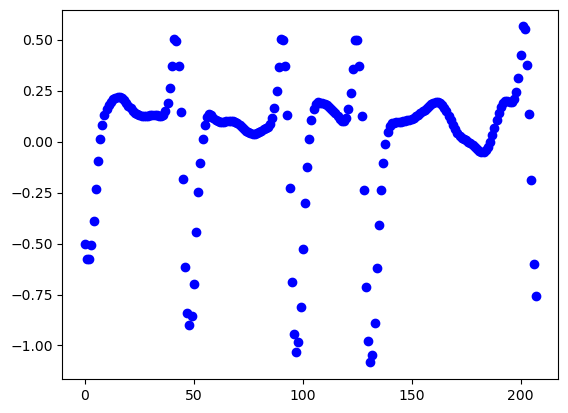

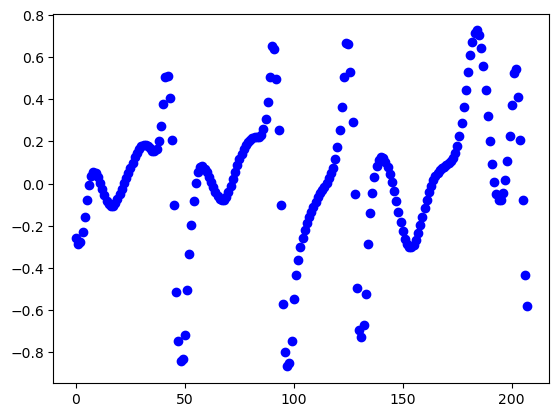

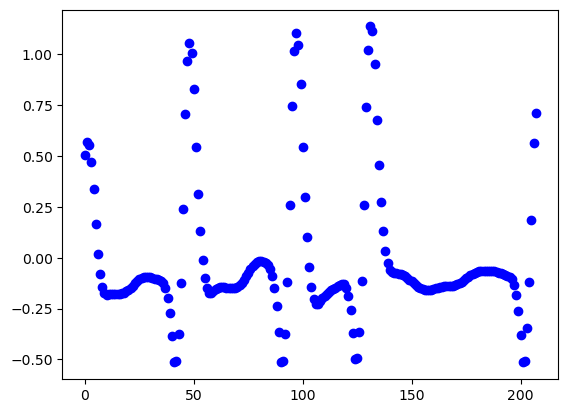

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


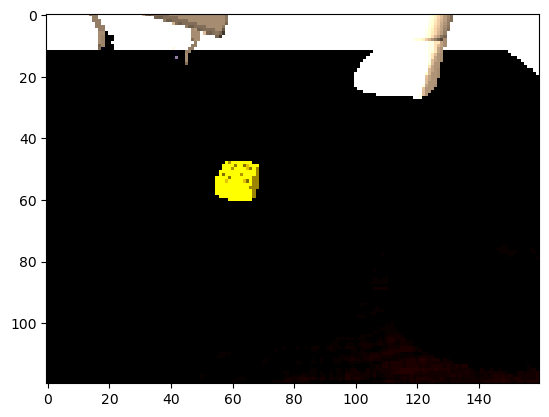

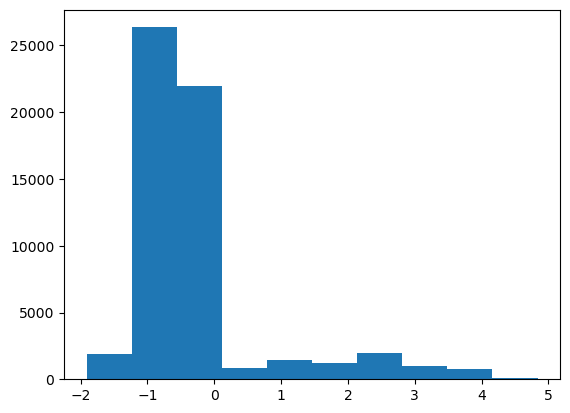

In [12]:
dataloader = VRDataLoader('data_reaching_frank_ronak', 1, 5, batch_size=128)

states = dataloader.states
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#set outliers to 0 (where |x| > 1)
for i in range(len(states)):
    if abs(states[i][0]) > 1:
        #interpolate between two adjacent states
        #if either value adjacent is out of bounds, use the other
        if i == 0:
            states[i][0] = states[i+1][0]
        elif i == states.shape[0] - 1:
            states[i][0] = states[i-1][0]
        else:
            states[i][0] = (states[i-1][0] + states[i+1][0]) / 2
    if abs(states[i][1]) > 1:
        if i == 0:
            states[i][1] = states[i+1][1]
        elif i == states.shape[0] - 1:
            states[i][1] = states[i-1][1]
        else:
            states[i][1] = (states[i-1][1] + states[i+1][1]) / 2
    if abs(states[i][2]) > 1:
        if i == 0:
            states[i][2] = states[i+1][2]
        elif i == states.shape[0] - 1:
            states[i][2] = states[i-1][2]
        else:
            states[i][2] = (states[i-1][2] + states[i+1][2]) / 2

#apply a gaussian filter to smooth out the data
gaussian_filter = np.array([1, 2, 3, 4, 5, 4, 3, 2, 1])
gaussian_filter = gaussian_filter / np.sum(gaussian_filter)

states = states.cpu().numpy()
for i in range(6):
    states[:, i] = np.convolve(states[:, i], gaussian_filter, mode='same')
states = torch.tensor(states).to('cuda')

#plot x velocities
plt.plot([state[0].cpu() for state in states][0:500], 'bo')
plt.show()

#plot y velocities
plt.plot([state[1].cpu() for state in states][0:500], 'bo')
plt.show()

#plot z velocities
plt.plot([state[2].cpu() for state in states][0:500], 'bo')
plt.show()

#display image
plt.imshow(dataloader.rgb_images[0].permute(1,2,0))
plt.show()
#display histogram of image
plt.hist(dataloader.rgb_images[0].permute(1,2,0).flatten().cpu().numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


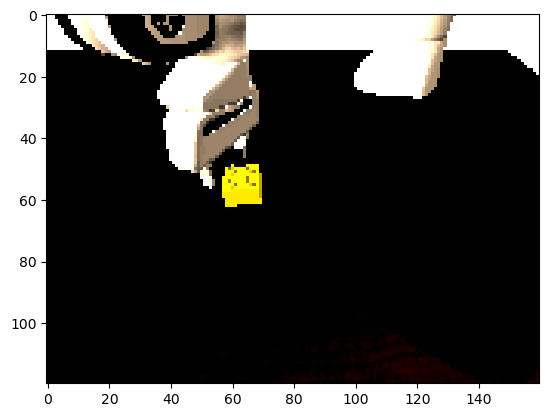

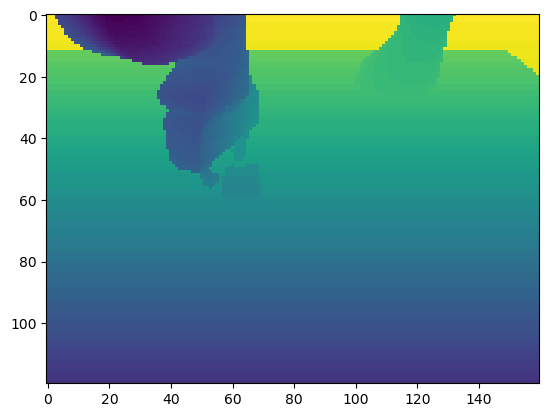

tensor([ 0.1339,  0.1856, -0.1088, -0.0885,  0.2179,  0.1847,  1.0000],
       device='cuda:0')
1


In [13]:

#show a random img from the dataset
import matplotlib.pyplot as plt
import random

idx = 0 #random.randint(0, len(dataloader))
data = dataloader[idx]
rgb_img, depth_img, state = data[0][0], data[1][0], data[2][0]

# plt.imshow(rgb_img.to(device).permute(1, 2, 0))
plt.imshow(rgb_img.permute(1, 2, 0))
plt.show()

# plt.imshow(depth_img.to(device).permute(1, 2, 0))
plt.imshow(depth_img.permute(1, 2, 0))
plt.show()

print(state)

print(len(dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


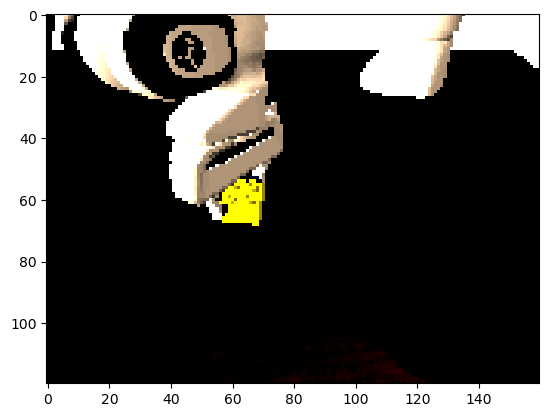

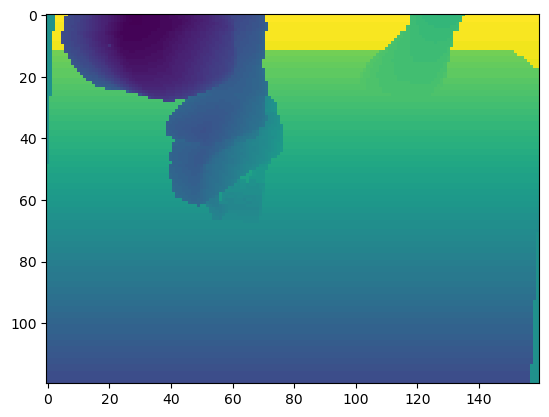

In [14]:
#add data augmentation
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(0, shear=3),
    torchvision.transforms.RandomAffine(0, scale=(0.98, 1.02)),
    # torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.05),
    # torchvision.transforms.RandomApply([torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.5),
])

def applyTransforms(rgb_img, depth_img):
    rngstate = torch.random.get_rng_state()
    rgb_img = transform(rgb_img)
    torch.random.set_rng_state(rngstate)
    depth_img = transform(depth_img)
    return rgb_img, depth_img

idx = random.randint(0, len(dataloader))
print(idx)
data = dataloader[idx]
rgb_img, depth_img, state = data[0][1], data[1][1], data[2][1]

rgb_img, depth_img = applyTransforms(rgb_img, depth_img)

#apply same transform to both depth and rgb image
plt.imshow(rgb_img.permute(1, 2, 0))
plt.show()

plt.imshow(depth_img.permute(1, 2, 0))
plt.show()

In [15]:
class LcLoss(nn.Module):
    def __init__(self):
        super(LcLoss, self).__init__()

    def forward(self, pred, target):
        loss = torch.zeros(pred.shape[0])
        for i in range(pred.shape[0]):
            p = pred[i]
            t = target[i]
            loss[i] = torch.arccos(torch.dot(t, p) / (torch.norm(t) * torch.norm(p)))
        
        return torch.sum(loss)

class LgLoss(nn.Module):
    def __init__(self):
        super(LgLoss, self).__init__()

    def forward(self, pred, target):
        loss = torch.zeros(pred.shape[0])
        for i in range(pred.shape[0]):
            p = pred[i]
            t = target[i]
            loss[i] = p * torch.log(t) - (1 - p) * torch.log(1 - t)
        return torch.sum(loss)

In [16]:
loss_weights = [1, 0.01, 0.005, 0.0001]

def train(model, data_loader, num_epochs, learning_rate, device):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    L1_loss = nn.L1Loss()
    L2_loss = nn.MSELoss()
    L_c_loss = LcLoss()
    L_g_loss = nn.CrossEntropyLoss()
    print(len(data_loader))
    for epoch in range(num_epochs):
        for i in range(len(data_loader)):
            rgb_img, depth_img, state = data_loader[i]
            rgb_img = rgb_img
            depth_img = depth_img

            #get rgb and depth images
            rgb_img = rgb_img.to(device).float()
            depth_img = depth_img.to(device).float()

            
            #apply data augmentation
            # rgb_img, depth_img = applyTransforms(rgb_img, depth_img)
            
            #add batch dimension
            state = state.to(device).float()

            optimizer.zero_grad()
            output = model(rgb_img, depth_img)
            
            #calculate combined loss
            # loss = L1_loss(output[0:3], state[0:3]) * loss_weights[0]
            #combine 0:3 and 6
            important_output = torch.cat((output[:, 0:3], output[:, 6].unsqueeze(1)), dim=1)
            important_state = torch.cat((state[:, 0:3], state[:, 6].unsqueeze(1)), dim=1)
            
            loss = L1_loss(important_output, important_state) # * loss_weights[1]
            # loss += L_c_loss(output[:, 0:6], state[:, 0:6]) * loss_weights[2]
            # loss += L_g_loss(output[:, 6], state[:, 6]) * loss_weights[3]
            

            loss.backward()
            optimizer.step()

            print(f'Epoch: {epoch}, Iteration: {i}, Loss: {loss.item()}')
    

In [17]:
#train the model
# device = torch.device('cuda')
model = VRNet().to(device)

In [18]:
train(model, dataloader, 500, 0.0005, device)

1
Epoch: 0, Iteration: 0, Loss: 0.4398137331008911
Epoch: 1, Iteration: 0, Loss: 0.4482448101043701
Epoch: 2, Iteration: 0, Loss: 0.4285357594490051
Epoch: 3, Iteration: 0, Loss: 0.46141311526298523
Epoch: 4, Iteration: 0, Loss: 0.43725353479385376
Epoch: 5, Iteration: 0, Loss: 0.4573383331298828
Epoch: 6, Iteration: 0, Loss: 0.4329323172569275
Epoch: 7, Iteration: 0, Loss: 0.43585458397865295
Epoch: 8, Iteration: 0, Loss: 0.46752744913101196
Epoch: 9, Iteration: 0, Loss: 0.451850563287735
Epoch: 10, Iteration: 0, Loss: 0.4469761550426483
Epoch: 11, Iteration: 0, Loss: 0.47594475746154785
Epoch: 12, Iteration: 0, Loss: 0.4260285496711731
Epoch: 13, Iteration: 0, Loss: 0.4512803256511688
Epoch: 14, Iteration: 0, Loss: 0.3913883864879608
Epoch: 15, Iteration: 0, Loss: 0.4537215828895569
Epoch: 16, Iteration: 0, Loss: 0.402230441570282
Epoch: 17, Iteration: 0, Loss: 0.4417738914489746
Epoch: 18, Iteration: 0, Loss: 0.40332382917404175
Epoch: 19, Iteration: 0, Loss: 0.4234864115715027
Epoc

In [19]:
#test model on an example image
import numpy as np
import random
idx = random.randint(0, len(dataloader))
rgb_img, depth_img, state = dataloader[idx][0][0], dataloader[idx][1][0], dataloader[idx][2][0]

model.eval()
rgb_img = rgb_img.unsqueeze(0).to(device).float() 
depth_img = depth_img.unsqueeze(0).to(device).float()

rgb_img = rgb_img.permute(0, 1, 2, 3)
depth_img = depth_img.permute(0, 1, 2, 3)

print(rgb_img.shape, depth_img.shape)
output = model(rgb_img, depth_img)

#show output (no scientific notation)
print('output: {} {} {} {}'.format(output[0][0].item(), output[0][1].item(), output[0][2].item(), output[0][6].item(),))
print('mse: ', np.mean((output.detach().cpu().numpy()[0:2] - state.detach().cpu().numpy())[0:2] ** 2))
print(state)

# print(rgb_img.shape)
# plt.imshow(rgb_img.permute(0, 2, 3, 1).cpu()[0])
# plt.show()

# plt.savefig(rgb_img.permute(0, 2, 3, 1).cpu()[0])
# plt.savefig(depth_img.permute(0, 2, 3, 1).cpu()[0])
# plt.imshow(depth_img.permute(0, 2, 3, 1).cpu()[0])
# plt.show()

# print(state)


torch.Size([1, 3, 120, 160]) torch.Size([1, 1, 120, 160])
output: 0.10297568887472153 0.052596013993024826 -0.10981050878763199 1.001320242881775
mse:  0.13238564
tensor([ 0.0231,  0.6047, -0.0615, -0.1069,  0.5380,  0.5579,  1.0000],
       device='cuda:0')


In [20]:
model_name = 'model_frank_reach_ronak_500epoch_0.0005lr.pt'
#save the model
torch.save(model.state_dict(), model_name)

#load the model
model = VRNet().to(device)
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>